In [1]:
#default_exp callback.training

# Training Callbacks
> Callbacks to help during training, including `fit_one_cycle`, the LR Finder, and hyper-parameter scheduling

In [2]:
#export
# Contains code used/modified by fastai_minima author from fastai
# Copyright 2019 the fast.ai team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language

In [3]:
#hide
from nbdev.showdoc import *
from fastcore.test import *

In [76]:
#export
from fastcore.basics import store_attr, patch
from fastcore.foundation import L
from fastcore.meta import delegates
from fastcore.xtras import is_listy

from fastai_minima.optimizer import convert_params

from fastai_minima.callback.core import Callback, CancelValidException, CancelFitException
from fastai_minima.learner import Learner, Recorder
from fastai_minima.utils import tensor, defaults, params

import functools, math, collections

import os

import matplotlib.pyplot as plt
import numpy as np

import torch

## Annealing

In [5]:
#export
class _Annealer:
    def __init__(self, f, start, end): store_attr('f,start,end')
    def __call__(self, pos): return self.f(self.start, self.end, pos)

In [6]:
#export
def annealer(f):
    "Decorator to make `f` return itself partially applied."
    @functools.wraps(f)
    def _inner(start, end): return _Annealer(f, start, end)
    return _inner

This is the decorator we will use for all of our scheduling functions, as it transforms a function taking `(start, end, pos)` to something taking `(start, end)` and return a function depending of `pos`.

In [7]:
#export
#TODO Jeremy, make this pickle
#@annealer
#def SchedLin(start, end, pos): return start + pos*(end-start)
#@annealer
#def SchedCos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
#@annealer
#def SchedNo (start, end, pos): return start
#@annealer
#def SchedExp(start, end, pos): return start * (end/start) ** pos
#
#SchedLin.__doc__ = "Linear schedule function from `start` to `end`"
#SchedCos.__doc__ = "Cosine schedule function from `start` to `end`"
#SchedNo .__doc__ = "Constant schedule function with `start` value"
#SchedExp.__doc__ = "Exponential schedule function from `start` to `end`"

In [8]:
#export
def sched_lin(start, end, pos): return start + pos*(end-start)
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
def sched_no (start, end, pos): return start
def sched_exp(start, end, pos): return start * (end/start) ** pos

def SchedLin(start, end): 
    "Linear schedule function from `start` to `end`"
    return _Annealer(sched_lin, start, end)

def SchedCos(start, end): 
    "Cosine schedule function from `start` to `end`"
    return _Annealer(sched_cos, start, end)

def SchedNo (start, end): 
    "Constant schedule function with `start` value"
    
    return _Annealer(sched_no,  start, end)
def SchedExp(start, end): 
    "Exponential schedule function from `start` to `end`"
    return _Annealer(sched_exp, start, end)

In [9]:
#hide
import pickle
tst = pickle.dumps(SchedCos(0, 5))

In [10]:
annealings = "NO LINEAR COS EXP".split()
p = torch.linspace(0.,1,100)
fns = [SchedNo, SchedLin, SchedCos, SchedExp]

In [11]:
#export
def SchedPoly(start, end, power):
    "Polynomial schedule (of `power`) function from `start` to `end`"
    def _inner(pos): return start + (end - start) * pos ** power
    return _inner

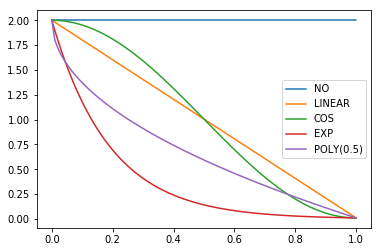

In [12]:
for fn, t in zip(fns, annealings):
    plt.plot(p, [fn(2, 1e-2)(o) for o in p], label=t)
f = SchedPoly(2,1e-2,0.5)
plt.plot(p, [f(o) for o in p], label="POLY(0.5)")
plt.legend();

In [13]:
show_doc(SchedLin)

<h4 id="SchedLin" class="doc_header"><code>SchedLin</code><a href="__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedLin</code>(**`start`**, **`end`**)

Linear schedule function from `start` to `end`

In [14]:
sched = SchedLin(0, 2)
test_eq(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.5, 1., 1.5, 2.])

In [15]:
show_doc(SchedCos)

<h4 id="SchedCos" class="doc_header"><code>SchedCos</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedCos</code>(**`start`**, **`end`**)

Cosine schedule function from `start` to `end`

In [16]:
sched = SchedCos(0, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.29289, 1., 1.70711, 2.])

In [17]:
show_doc(SchedNo)

<h4 id="SchedNo" class="doc_header"><code>SchedNo</code><a href="__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedNo</code>(**`start`**, **`end`**)

Constant schedule function with `start` value

In [18]:
sched = SchedNo(0, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0., 0., 0., 0.])

In [19]:
show_doc(SchedExp)

<h4 id="SchedExp" class="doc_header"><code>SchedExp</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedExp</code>(**`start`**, **`end`**)

Exponential schedule function from `start` to `end`

In [20]:
sched = SchedExp(1, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [1., 1.18921, 1.41421, 1.68179, 2.])

In [21]:
show_doc(SchedPoly)

<h4 id="SchedPoly" class="doc_header"><code>SchedPoly</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>SchedPoly</code>(**`start`**, **`end`**, **`power`**)

Polynomial schedule (of `power`) function from `start` to `end`

In [22]:
sched = SchedPoly(0, 2, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.125, 0.5, 1.125, 2.])

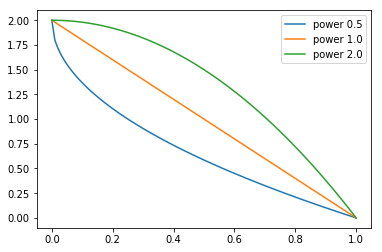

In [23]:
p = torch.linspace(0.,1,100)

pows = [0.5,1.,2.]
for e in pows:
    f = SchedPoly(2, 0, e)
    plt.plot(p, [f(o) for o in p], label=f'power {e}')
plt.legend();

In [24]:
#export
def combine_scheds(pcts, scheds):
    "Combine `scheds` according to `pcts` in one function"
    assert sum(pcts) == 1.
    pcts = tensor([0] + L(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        if int(pos) == 1: return scheds[-1](1.)
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos.item())
    return _inner

`pcts` must be a list of positive numbers that add up to 1 and is the same length as `scheds`. The generated function will use `scheds[0]` from 0 to `pcts[0]` then `scheds[1]` from `pcts[0]` to `pcts[0]+pcts[1]` and so forth.

/mnt/d/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  # Remove the CWD from sys.path while we load stuff.


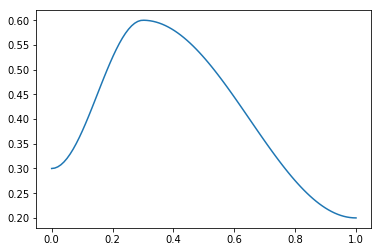

In [25]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3,0.7], [SchedCos(0.3,0.6), SchedCos(0.6,0.2)])
plt.plot(p, [f(o) for o in p]);

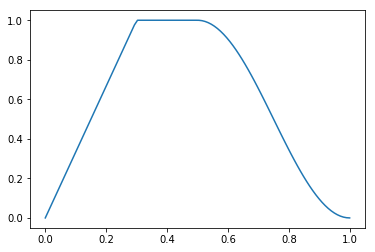

In [26]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3,0.2,0.5], [SchedLin(0.,1.), SchedNo(1.,1.), SchedCos(1., 0.)])
plt.plot(p, [f(o) for o in p]);

In [27]:
#hide
test_close([f(0.), f(0.15), f(0.3), f(0.4), f(0.5), f(0.7), f(1.)],
           [0., 0.5, 1., 1., 1., 0.65451, 0.])

In [28]:
#export
def combined_cos(pct, start, middle, end):
    "Return a scheduler with cosine annealing from `start`→`middle` & `middle`→`end`"
    return combine_scheds([pct,1-pct], [SchedCos(start, middle), SchedCos(middle, end)])

This is a useful helper function for the [1cycle policy](https://sgugger.github.io/the-1cycle-policy.html). `pct` is used for the `start` to `middle` part, `1-pct` for the `middle` to `end`. Handles floats or collection of floats. For example:

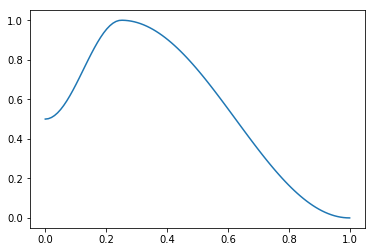

In [29]:
f = combined_cos(0.25,0.5,1.,0.)
plt.plot(p, [f(o) for o in p]);

In [30]:
#hide
test_close([f(0.), f(0.1), f(0.25), f(0.5), f(1.)], [0.5, 0.67275, 1., 0.75, 0.])
f = combined_cos(0.25, np.array([0.25,0.5]), np.array([0.5,1.]), np.array([0.,0.]))
for a,b in zip([f(0.), f(0.1), f(0.25), f(0.5), f(1.)],
               [[0.25,0.5], [0.33638,0.67275], [0.5,1.], [0.375,0.75], [0.,0.]]):
    test_close(a,b)

## ParamScheduler -

In [31]:
#export
class ParamScheduler(Callback):
    "Schedule hyper-parameters according to `scheds`"
    order,run_valid = 60,False

    def __init__(self, scheds): self.scheds = scheds
    def before_fit(self): 
        "Initialize container for hyper-parameters"
        self.hps = {p:[] for p in self.scheds.keys()}
        
    def before_batch(self): 
        "Set the proper hyper-parameters in the optimizer"
        self._update_val(self.pct_train)

    def _update_val(self, pct):
        for n,f in self.scheds.items(): self.opt.set_hyper(n, f(pct))

    def after_batch(self):
        "Record hyper-parameters of this batch"
        for p in self.scheds.keys(): self.hps[p].append(self.opt.hypers[-1][p])

    def after_fit(self):
        "Save the hyper-parameters in the recorder if there is one"
        if hasattr(self.learn, 'recorder') and hasattr(self, 'hps'): self.recorder.hps = self.hps

`scheds` is a dictionary with one key for each hyper-parameter you want to schedule, with either a scheduler or a list of schedulers as values (in the second case, the list must have the same length as the the number of parameters groups of the optimizer).

In [32]:
#hide
import torch
from torch.utils.data import TensorDataset, DataLoader
from fastai_minima.learner import DataLoaders
from torch import nn
def synth_dbunch(a=2, b=3, bs=16, n_train=10, n_valid=2):
    "A simple dataset where `x` is random and `y = a*x + b` plus some noise."
    def get_data(n):
        x = torch.randn(int(bs*n))
        return TensorDataset(x, a*x + b + 0.1*torch.randn(int(bs*n)))
    train_ds = get_data(n_train)
    valid_ds = get_data(n_valid)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)
    valid_dl = DataLoader(valid_ds, batch_size=bs, num_workers=0)
    return DataLoaders(train_dl, valid_dl)
def synth_learner(n_train=10, n_valid=2, lr=defaults.lr, **kwargs):
    data = synth_dbunch(n_train=n_train,n_valid=n_valid)
    return Learner(data, RegModel(), loss_func=nn.MSELoss(), lr=lr, **kwargs)

class RegModel(nn.Module):
    "A r"
    def __init__(self): 
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
    def forward(self, x): return x*self.a + self.b

In [33]:
learn = synth_learner()
sched = {'lr': SchedLin(1e-3, 1e-2)}
learn.fit(1, cbs=ParamScheduler(sched))
n = len(learn.dls.train)
test_close(learn.recorder.hps['lr'], [1e-3 + (1e-2-1e-3) * i/n for i in range(n)])

[0, 6.161931037902832, 4.104144096374512, '00:00']


/mnt/d/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


In [34]:
#hide
#test discriminative lrs
from torch import optim
from functools import partial
def _splitter(m): return convert_params([[m.a], [m.b]])

learn = synth_learner(splitter=_splitter)
sched = {'lr': combined_cos(0.5, np.array([1e-4,1e-3]), np.array([1e-3,1e-2]), np.array([1e-5,1e-4]))}
learn.fit(1, cbs=ParamScheduler(sched))

[0, 35.680267333984375, 15.556540489196777, '00:00']


In [35]:
show_doc(ParamScheduler.before_fit)

<h4 id="ParamScheduler.before_fit" class="doc_header"><code>ParamScheduler.before_fit</code><a href="__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>ParamScheduler.before_fit</code>()

Initialize container for hyper-parameters

In [36]:
show_doc(ParamScheduler.before_batch)

<h4 id="ParamScheduler.before_batch" class="doc_header"><code>ParamScheduler.before_batch</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>ParamScheduler.before_batch</code>()

Set the proper hyper-parameters in the optimizer

In [37]:
show_doc(ParamScheduler.after_batch)

<h4 id="ParamScheduler.after_batch" class="doc_header"><code>ParamScheduler.after_batch</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>ParamScheduler.after_batch</code>()

Record hyper-parameters of this batch

In [38]:
show_doc(ParamScheduler.after_fit)

<h4 id="ParamScheduler.after_fit" class="doc_header"><code>ParamScheduler.after_fit</code><a href="__main__.py#L22" class="source_link" style="float:right">[source]</a></h4>

> <code>ParamScheduler.after_fit</code>()

Save the hyper-parameters in the recorder if there is one

In [39]:
#export
@patch
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

The 1cycle policy was introduced by Leslie N. Smith et al. in [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120). It schedules the learning rate with a cosine annealing from `lr_max/div` to `lr_max` then `lr_max/div_final` (pass an array to `lr_max` if you want to use differential learning rates) and the momentum with cosine annealing according to the values in `moms`. The first phase takes `pct_start` of the training. You can optionally pass additional `cbs` and `reset_opt`.

In [40]:
#Integration test: training a few epochs should make the model better
learn = synth_learner(lr=1e-2)
xb,yb = learn.dls.one_batch()
init_loss = learn.loss_func(learn.model(xb), yb)
learn.fit_one_cycle(2)
xb,yb = learn.dls.one_batch()
final_loss = learn.loss_func(learn.model(xb), yb)
assert final_loss < init_loss

[0, 26.9017391204834, 28.374866485595703, '00:00']
[1, 26.332597732543945, 27.804462432861328, '00:00']


In [41]:
#Scheduler test
lrs,moms = learn.recorder.hps['lr'],learn.recorder.hps['mom']
test_close(lrs,  [combined_cos(0.25,1e-2/25,1e-2,1e-7)(i/20) for i in range(20)])
test_close(moms, [combined_cos(0.25,0.95,0.85,0.95)(i/20) for i in range(20)])

In [42]:
#export
@patch
def plot_sched(self:Recorder, keys=None, figsize=None):
    keys = self.hps.keys() if keys is None else L(keys)
    rows,cols = (len(keys)+1)//2, min(2, len(keys))
    figsize = figsize or (6*cols,4*rows)
    _, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.flatten() if len(keys) > 1 else L(axs)
    for p,ax in zip(keys, axs):
        ax.plot(self.hps[p])
        ax.set_ylabel(p)

In [43]:
#hide
#test discriminative lrs
def _splitter(m): return convert_params([[m.a], [m.b]])
learn = synth_learner(splitter=_splitter)
learn.fit_one_cycle(1, lr_max=slice(1e-3,1e-2))
#n = len(learn.dls.train)
#est_close(learn.recorder.hps['lr'], [1e-3 + (1e-2-1e-3) * i/n for i in range(n)])

[0, 8.607049942016602, 12.220094680786133, '00:00']


In [44]:
learn = synth_learner()
learn.fit_one_cycle(2)

[0, 17.926883697509766, 20.23248291015625, '00:00']
[1, 17.875675201416016, 20.192337036132812, '00:00']


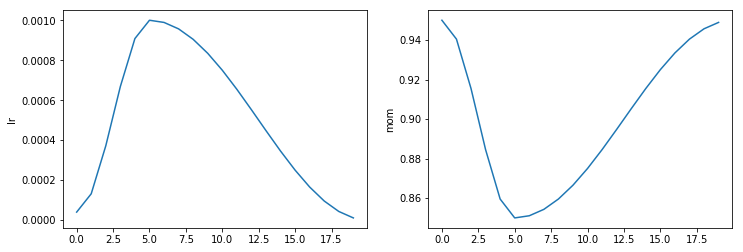

In [45]:
learn.recorder.plot_sched()

In [46]:
#export
@patch
def fit_flat_cos(self:Learner, n_epoch, lr=None, div_final=1e5, pct_start=0.75, wd=None,
                 cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` at flat `lr` before a cosine annealing."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr is None else lr)
    lr = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr, lr, lr/div_final)}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

In [47]:
learn = synth_learner()
learn.fit_flat_cos(2)

[0, 18.8897762298584, 17.584243774414062, '00:00']
[1, 18.792402267456055, 17.517009735107422, '00:00']


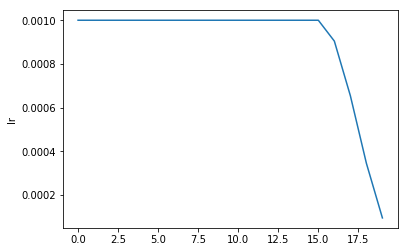

In [48]:
learn.recorder.plot_sched()

In [49]:
#export
@patch
def fit_sgdr(self:Learner, n_cycles, cycle_len, lr_max=None, cycle_mult=2, cbs=None, reset_opt=False, wd=None):
    "Fit `self.model` for `n_cycles` of `cycle_len` using SGDR."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    n_epoch = cycle_len * (cycle_mult**n_cycles-1)//(cycle_mult-1)
    pcts = [cycle_len * cycle_mult**i / n_epoch for i in range(n_cycles)]
    scheds = [SchedCos(lr_max, 0) for _ in range(n_cycles)]
    scheds = {'lr': combine_scheds(pcts, scheds)}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

This schedule was introduced by Ilya Loshchilov et al. in [SGDR: Stochastic Gradient Descent with Warm Restarts](https://arxiv.org/abs/1608.03983). It consists of `n_cycles` that are cosine annealings from `lr_max` (defaults to the `Learner` lr) to 0, with a length of `cycle_len * cycle_mult**i` for the `i`-th cycle (first one is `cycle_len`-long, then we multiply the length by `cycle_mult` at each epoch). You can optionally pass additional `cbs` and `reset_opt`.

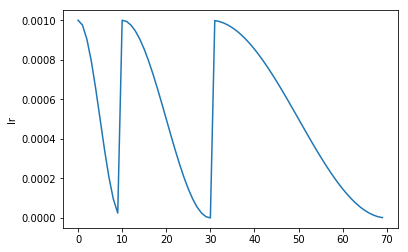

In [50]:
#slow
learn = synth_learner()
with learn.no_logging(): learn.fit_sgdr(3, 1)
test_eq(learn.n_epoch, 7)
iters = [k * len(learn.dls.train) for k in [0,1,3,7]]
for i in range(3):
    n = iters[i+1]-iters[i]
    #The start of a cycle can be mixed with the 0 of the previous cycle with rounding errors, so we test at +1
    test_close(learn.recorder.lrs[iters[i]+1:iters[i+1]], [SchedCos(learn.lr, 0)(k/n) for k in range(1,n)])

learn.recorder.plot_sched()

In [53]:
#export
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

In [54]:
learn.fine_tune(1)

[0, 8.343265533447266, 9.842547416687012, '00:00']
[0, 8.404812812805176, 9.797117233276367, '00:00']


## LRFind -

In [55]:
#export
class LRFinder(ParamScheduler):
    "Training with exponentially growing learning rate"
    def __init__(self, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True):
        if is_listy(start_lr):
            self.scheds = {'lr': [SchedExp(s, e) for (s,e) in zip(start_lr,end_lr)]}
        else: self.scheds = {'lr': SchedExp(start_lr, end_lr)}
        self.num_it,self.stop_div = num_it,stop_div

    def before_fit(self):
        "Initialize container for hyper-parameters and save the model"
        super().before_fit()
        self.learn.save('_tmp')
        self.best_loss = float('inf')

    def before_batch(self):
        "Record hyper-parameters of this batch and potentially stop training"
        self._update_val(self.train_iter/self.num_it)

    def after_batch(self):
        "Set the proper hyper-parameters in the optimizer"
        super().after_batch()
        if self.smooth_loss < self.best_loss: self.best_loss = self.smooth_loss
        if self.smooth_loss > 4*self.best_loss and self.stop_div: raise CancelFitException()
        if self.train_iter >= self.num_it: raise CancelFitException()

    def before_validate(self): 
        "Skip the validation part of training"
        raise CancelValidException()

    def after_fit(self):
        "Save the hyper-parameters in the recorder if there is one and load the original model"
        self.learn.opt.zero_grad() #Need to zero the gradients of the model before detaching the optimizer for future fits
        tmp_f = self.path/self.model_dir/'_tmp.pth'
        if tmp_f.exists():
            self.learn.load('_tmp', with_opt=True)
            os.remove(tmp_f)

In [ ]:
from fastai.vision.all import *
set_seed(99, True)
path = untar_data(URLs.PETS)/'images'

image_files = get_image_files(path)
if sys.platform == "win32" and IN_NOTEBOOK:
    image_files = random.choices(image_files, k=int(len(image_files)/8))
    print("Randomly select 1/8 files in NOTEBOOK on Windows to save time")

# pickle can't serializer lamda function.
def _label_func(x):
    return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, image_files, valid_pct=0.2,
    label_func=_label_func, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet18)
learn.fit(1)
learn.opt.state_dict()['state'][1]['grad_avg']

epoch,train_loss,valid_loss,time
0,0.073966,0.037551,00:17


tensor([-5.0481e-03,  1.8275e-02,  0.0000e+00, -9.6743e-03,  0.0000e+00,
        -6.3870e-03,  5.7152e-03,  0.0000e+00,  1.1021e-03,  0.0000e+00,
        -6.3257e-03, -2.2116e-03, -2.0698e-03,  0.0000e+00,  1.6720e-02,
        -8.3156e-03, -7.9550e-03, -8.6084e-04, -9.1418e-04, -6.1664e-04,
        -6.1177e-03, -1.3059e-02,  1.1902e-02, -1.5803e-02, -2.4922e-02,
         2.8713e-02,  2.4694e-02,  4.4344e-03, -1.5961e-03,  7.6739e-03,
         7.4914e-03, -1.3638e-02, -3.0059e-03,  2.1931e-02,  5.9706e-03,
         4.2344e-03,  0.0000e+00,  8.9989e-03,  0.0000e+00, -2.0990e-02,
        -1.3239e-03, -2.4970e-03,  2.1901e-03, -2.4358e-02, -1.6894e-02,
        -1.0530e-02,  5.4196e-05,  1.0004e-02,  0.0000e+00, -5.9237e-03,
         2.4995e-02,  1.6727e-02,  1.2013e-02, -1.1876e-02, -4.2850e-03,
         1.7863e-02,  1.6690e-02,  1.3798e-03,  9.8079e-03, -2.9349e-04,
         7.1303e-03,  3.3969e-02,  2.9827e-03, -1.5872e-02], device='cuda:0')

tensor([-5.0481e-03,  1.8275e-02,  0.0000e+00, -9.6743e-03,  0.0000e+00,
        -6.3870e-03,  5.7152e-03,  0.0000e+00,  1.1021e-03,  0.0000e+00,
        -6.3257e-03, -2.2116e-03, -2.0698e-03,  0.0000e+00,  1.6720e-02,
        -8.3156e-03, -7.9550e-03, -8.6084e-04, -9.1418e-04, -6.1664e-04,
        -6.1177e-03, -1.3059e-02,  1.1902e-02, -1.5803e-02, -2.4922e-02,
         2.8713e-02,  2.4694e-02,  4.4344e-03, -1.5961e-03,  7.6739e-03,
         7.4914e-03, -1.3638e-02, -3.0059e-03,  2.1931e-02,  5.9706e-03,
         4.2344e-03,  0.0000e+00,  8.9989e-03,  0.0000e+00, -2.0990e-02,
        -1.3239e-03, -2.4970e-03,  2.1901e-03, -2.4358e-02, -1.6894e-02,
        -1.0530e-02,  5.4196e-05,  1.0004e-02,  0.0000e+00, -5.9237e-03,
         2.4995e-02,  1.6727e-02,  1.2013e-02, -1.1876e-02, -4.2850e-03,
         1.7863e-02,  1.6690e-02,  1.3798e-03,  9.8079e-03, -2.9349e-04,
         7.1303e-03,  3.3969e-02,  2.9827e-03, -1.5872e-02], device='cuda:0')

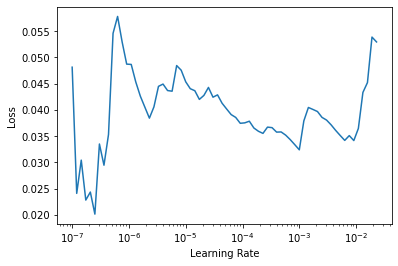

In [ ]:
#slow
learn.lr_find()
learn.opt.state_dict()['state'][1]['grad_avg']

tensor([-5.0481e-03,  1.8275e-02,  0.0000e+00, -9.6743e-03,  0.0000e+00,
        -6.3870e-03,  5.7152e-03,  0.0000e+00,  1.1021e-03,  0.0000e+00,
        -6.3257e-03, -2.2116e-03, -2.0698e-03,  0.0000e+00,  1.6720e-02,
        -8.3156e-03, -7.9550e-03, -8.6084e-04, -9.1418e-04, -6.1664e-04,
        -6.1177e-03, -1.3059e-02,  1.1902e-02, -1.5803e-02, -2.4922e-02,
         2.8713e-02,  2.4694e-02,  4.4344e-03, -1.5961e-03,  7.6739e-03,
         7.4914e-03, -1.3638e-02, -3.0059e-03,  2.1931e-02,  5.9706e-03,
         4.2344e-03,  0.0000e+00,  8.9989e-03,  0.0000e+00, -2.0990e-02,
        -1.3239e-03, -2.4970e-03,  2.1901e-03, -2.4358e-02, -1.6894e-02,
        -1.0530e-02,  5.4196e-05,  1.0004e-02,  0.0000e+00, -5.9237e-03,
         2.4995e-02,  1.6727e-02,  1.2013e-02, -1.1876e-02, -4.2850e-03,
         1.7863e-02,  1.6690e-02,  1.3798e-03,  9.8079e-03, -2.9349e-04,
         7.1303e-03,  3.3969e-02,  2.9827e-03, -1.5872e-02], device='cuda:0')

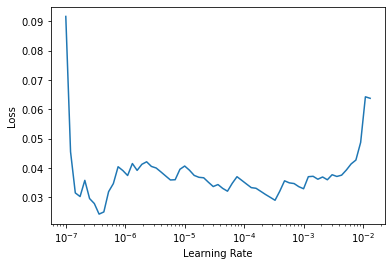

In [ ]:
#slow
learn.lr_find()
learn.opt.state_dict()['state'][1]['grad_avg']

In [69]:
#slow
import tempfile
from fastcore.basics import range_of
from fastcore.xtras import Path

with tempfile.TemporaryDirectory() as d:
    learn = synth_learner(path=Path(d))
    init_a,init_b = learn.model.a,learn.model.b
    with learn.no_logging(): learn.fit(20, cbs=LRFinder(num_it=100))
    assert len(learn.recorder.lrs) <= 100
    test_eq(len(learn.recorder.lrs), len(learn.recorder.losses))
    #Check stop if diverge
    if len(learn.recorder.lrs) < 100: assert learn.recorder.losses[-1] > 4 * min(learn.recorder.losses)
    #Test schedule
    test_eq(learn.recorder.lrs, [SchedExp(1e-7, 10)(i/100) for i in range_of(learn.recorder.lrs)])
    #No validation data
    test_eq([len(v) for v in learn.recorder.values], [1 for _ in range_of(learn.recorder.values)])
    #Model loaded back properly
    test_eq(learn.model.a, init_a)
    test_eq(learn.model.b, init_b)
    test_eq(learn.opt.state_dict()['state'], {})

In [70]:
show_doc(LRFinder.before_fit)

<h4 id="LRFinder.before_fit" class="doc_header"><code>LRFinder.before_fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>LRFinder.before_fit</code>()

Initialize container for hyper-parameters and save the model

In [71]:
show_doc(LRFinder.before_batch)

<h4 id="LRFinder.before_batch" class="doc_header"><code>LRFinder.before_batch</code><a href="__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>LRFinder.before_batch</code>()

Record hyper-parameters of this batch and potentially stop training

In [72]:
show_doc(LRFinder.after_batch)

<h4 id="LRFinder.after_batch" class="doc_header"><code>LRFinder.after_batch</code><a href="__main__.py#L20" class="source_link" style="float:right">[source]</a></h4>

> <code>LRFinder.after_batch</code>()

Set the proper hyper-parameters in the optimizer

In [73]:
show_doc(LRFinder.before_validate)

<h4 id="LRFinder.before_validate" class="doc_header"><code>LRFinder.before_validate</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>LRFinder.before_validate</code>()

Skip the validation part of training

In [74]:
#export
@patch
def plot_lr_find(self:Recorder, skip_end=5):
    "Plot the result of an LR Finder test (won't work if you didn't do `learn.lr_find()` before)"
    lrs    = self.lrs    if skip_end==0 else self.lrs   [:-skip_end]
    losses = self.losses if skip_end==0 else self.losses[:-skip_end]
    fig, ax = plt.subplots(1,1)
    ax.plot(lrs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')

In [77]:
#export
SuggestedLRs = collections.namedtuple('SuggestedLRs', ['lr_min', 'lr_steep'])

In [78]:
#export
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggestions=True):
    "Launch a mock training to find a good learning rate, return lr_min, lr_steep if `suggestions` is True"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if show_plot: self.recorder.plot_lr_find()
    if suggestions:
        lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
        if len(losses) == 0: return
        lr_min = lrs[losses.argmin()].item()
        grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
        lr_steep = lrs[grads.argmin()].item()
        return SuggestedLRs(lr_min/10.,lr_steep)


First introduced by Leslie N. Smith in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf), the LR Finder trains the model with exponentially growing learning rates from `start_lr` to `end_lr` for `num_it` and stops in case of divergence (unless `stop_div=False`) then plots the losses vs the learning rates with a log scale. 

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Those two values are returned by default by the Learning Rate Finder.

Minimum/10: 3.31e-01, steepest point: 9.12e-07


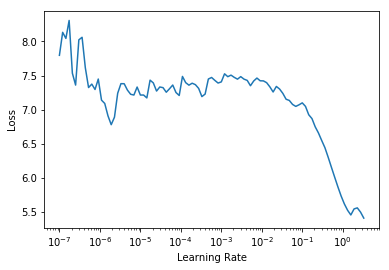

In [79]:
#slow
with tempfile.TemporaryDirectory() as d:
    learn = synth_learner(path=Path(d))
    weights_pre_lr_find = L(learn.model.parameters())
    lr_min,lr_steep = learn.lr_find()
    weights_post_lr_find = L(learn.model.parameters())
test_eq(weights_pre_lr_find, weights_post_lr_find)
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 